# Paper Plots: Results
This notebook will use the tabular predictions in the predictions subfolder to evaluate the results.

In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score as cat_acc
#from sklearn.metrics import accuracy_score as cat_acc

from sklearn.metrics import classification_report as clf_rep
import numpy as np
import pandas as pd

TRAINING_PATH = "./data/ISIC2018/ISIC2018_Task3_Training_Input/"
label_path = f"{TRAINING_PATH}metadata.csv"
PREDICTION_PATH = "./predictions/"
df_all = pd.read_csv(label_path)
df_Bevan = pd.read_csv("Bevan_corrected.csv")
df_all = pd.merge(df_all,df_Bevan,left_on="image",right_on="image")

In [2]:
df_all.head()

,image,lesion,estimated_ita,fitzpatrick_Bevan,fitzpatrick_corrected
0,ISIC_0024306.jpg,NV,40.059917,1,1
1,ISIC_0024307.jpg,NV,40.497098,1,1
2,ISIC_0024308.jpg,NV,46.131533,1,1
3,ISIC_0024309.jpg,NV,36.834707,1,1
4,ISIC_0024311.jpg,NV,45.215332,1,1


In [3]:
experiments = ["01DataShift00Compare41","01DataShift02Compare41","01DataShift04Compare41","01DataShift01Threshold41","01DataShift03Threshold41","01DataShift05Threshold41","03DataShift01RP","03DataShift02RP","03DataShift03RP","03DataShift04RP2","03DataShift05RP2","03DataShift06RP2"]
Controls = experiments[0:3]
IBM = experiments[3:6]
RP = experiments[6:9]
RP2 = experiments[9:]
Setups = [Controls,IBM,RP,RP2]

### Cat acc on baseline - IBM, RP, RP2

In [ ]:
Cat_Accs_skin_tone = np.zeros((6,3,3)) # skin types (6) x runs x ITA label algorithms ## Undefined ITA were removed!!!
ITA_thresholds = [180,55,41,28,19,10,-180]
for j in range(len(Controls)):
    exp_name = Controls[j]
    df_pred = pd.read_csv(f"{PREDICTION_PATH}predictions_{exp_name}.csv")
    df_merged = pd.merge(df_all, df_pred, left_on='image', right_on='image')
    # cat_acc
    for i in range(len(ITA_thresholds)-1):
        df_filtered = df_merged[df_merged['estimated_ita'] > ITA_thresholds[i+1]]
        df_filtered = df_filtered[df_filtered['estimated_ita'] <= ITA_thresholds[i]]
        y_pred = df_filtered["predicted_lesion"].values
        y_true = df_filtered["lesion"].values
        Cat_Accs_skin_tone[i,j,0] = cat_acc(y_true,y_pred)

In [ ]:
Fitzpatrick_types = [1,2,3,4,5,6]
for j in range(len(Controls)):
    exp_name = Controls[j]
    df_pred = pd.read_csv(f"{PREDICTION_PATH}predictions_{exp_name}.csv")
    df_merged = pd.merge(df_all, df_pred, left_on='image', right_on='image')
    for i in range(len(Fitzpatrick_types)):
        df_filtered = df_merged[df_merged['fitzpatrick_Bevan'] == Fitzpatrick_types[i]]
        #df_filtered = df_filtered[df_filtered['estimated_ita'] <= ITA_thresholds[i]]
        y_pred = df_filtered["predicted_lesion"].values
        y_true = df_filtered["lesion"].values
        Cat_Accs_skin_tone[i,j,1] = cat_acc(y_true,y_pred)

In [ ]:
for j in range(len(Controls)):
    exp_name = Controls[j]
    df_pred = pd.read_csv(f"{PREDICTION_PATH}predictions_{exp_name}.csv")
    df_merged = pd.merge(df_all, df_pred, left_on='image', right_on='image')
    for i in range(len(Fitzpatrick_types)):
        df_filtered = df_merged[df_merged['fitzpatrick_corrected'] == Fitzpatrick_types[i]]
        #df_filtered = df_filtered[df_filtered['estimated_ita'] <= ITA_thresholds[i]]
        y_pred = df_filtered["predicted_lesion"].values
        y_true = df_filtered["lesion"].values
        Cat_Accs_skin_tone[i,j,2] = cat_acc(y_true,y_pred)

[[0.74584378 0.68593231 0.68614078]
 [0.69016407 0.82849645 0.8241392 ]
 [0.66186467 0.78027068 0.89252972]
 [0.53981481 0.80917874 0.92384454]
 [0.5        0.84673721 0.88888889]
 [1.         0.67629102 1.        ]]


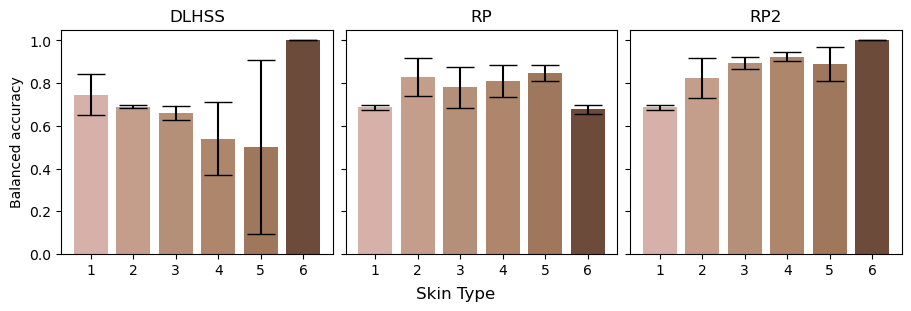

In [14]:
stats_acc_skin_tone = np.zeros((6,2,3)) # 7 lesions, (mean,std), 3 ITA labels
stats_acc_skin_tone[:,0,:] = np.mean(Cat_Accs_skin_tone,axis=1)
stats_acc_skin_tone[:,1,:] = np.std(Cat_Accs_skin_tone,axis=1)
print(stats_acc_skin_tone[:,0,:])
skin_colors = ["#d5b1a9","#c59d8b","#b59079","#ae866c","#9f775c","#6d4b3a"]


# New plot for the presentation
#plt.plot(["Control","Shift","SinGAN","Oversampled"],stats_acc[:,0],"o")

ITA_algorithms = ["DLHSS","RP","RP2"]
fig, ax = plt.subplots(1,3,figsize=(9,3),sharey=True,sharex=True,constrained_layout=True)
for g in range(stats_acc_skin_tone.shape[2]):
    ax[g].bar(["1","2","3","4","5","6"], stats_acc_skin_tone[:,0,g],color=skin_colors)
    ax[g].errorbar(["1","2","3","4","5","6"], stats_acc_skin_tone[:,0,g], yerr=stats_acc_skin_tone[:,1,g], fmt="o",markersize=0,color="k",capsize=10)
    ax[g].set_title(ITA_algorithms[g])
ax[0].set_ylabel("Balanced accuracy")
fig.supxlabel("Skin Type")
plt.savefig("Acc_skintone.eps",format='eps',dpi=1200)
plt.show()

## Different metrics for data shift

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
acc_prec_rec_f1 = np.zeros((4,3,4)) # 4 experimental setups x 3 repetitions x 4 metrics
for i in range(len(Setups)):
    setup = Setups[i]
    for j in range(len(setup)):
        exp_name = setup[j]
        df_pred = pd.read_csv(f"{PREDICTION_PATH}predictions_{exp_name}.csv")
        df_merged = pd.merge(df_all, df_pred, left_on='image', right_on='image')
        # cat_acc
        y_pred = df_merged["predicted_lesion"].values
        y_true = df_merged["lesion"].values
        acc_prec_rec_f1[i,j,0] = cat_acc(y_true,y_pred)
        acc_prec_rec_f1[i,j,1:] = precision_recall_fscore_support(y_true, y_pred,average="weighted")[:3]
    print(len(y_pred))
with np.printoptions(precision=3):
    print(np.mean(acc_prec_rec_f1,axis=1))
    print(np.std(acc_prec_rec_f1,axis=1))

The cell above will also print the size of the test sets. It becomes obvious that a RP2-based data shift experiment, defining all RP2-based dark skin images as the test set, does not make sense, as the lesion diversity would not be sufficient.

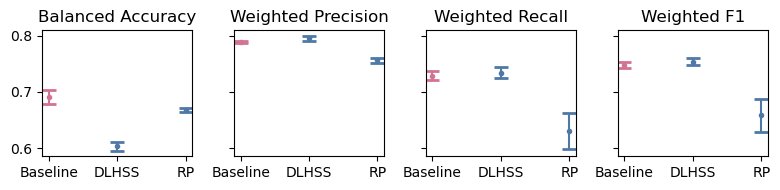

In [158]:
fig, ax = plt.subplots(1,4,figsize=(8,2),sharey=True)
for k in range(4):
    ax[k].errorbar(["Baseline","DLHSS","RP","RP2"][0], np.mean(acc_prec_rec_f1,axis=1)[0,k], yerr=np.std(acc_prec_rec_f1,axis=1)[0,k], color=["#d37295","#4e79a7","#4e79a7","4e79a7"][0],marker='o',markersize=2,capsize=5, markeredgewidth=2, linestyle='')
    ax[k].errorbar(["Baseline","DLHSS","RP","RP2"][1:3], np.mean(acc_prec_rec_f1,axis=1)[1:3,k], yerr=np.std(acc_prec_rec_f1,axis=1)[1:3,k], color=["#d37295","#4e79a7","#4e79a7","4e79a7"][1],marker='o',markersize=2,capsize=5, markeredgewidth=2, linestyle='')
    ax[k].set_title(["Balanced Accuracy","Weighted Precision","Weighted Recall","Weighted F1"][k])
    #plt.show()
    #plt.errorbar(["Control","Data Shift","SinGAN","Oversampled"], stats_acc[:,0], yerr=stats_acc[:,1], fmt="o",color=["#4e79a7","#4e79a7","#4e79a7"])
plt.tight_layout()
plt.savefig("DataShiftMetrics.eps",format='eps',dpi=1200)
plt.show()
